First submission using a logistic regression classifier.

Approach:
1 - view data
2 - choose columns which seem most viable
3 - visualise data

In [1]:
#read data
import pandas as pd
import numpy as np
from matplotlib import pyplot

pyplot.style.use('ggplot')

df = pd.read_csv('../input/train.csv')

# drop useless columns
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin', 'Fare'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


Throw away useless data

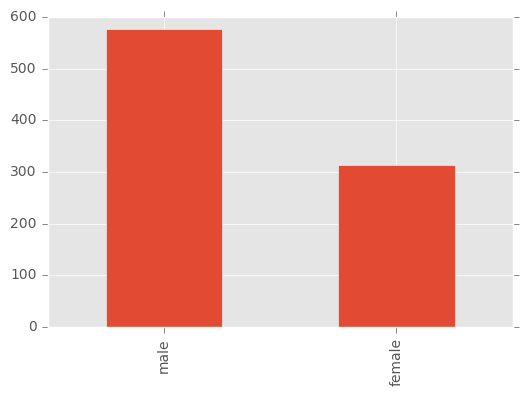

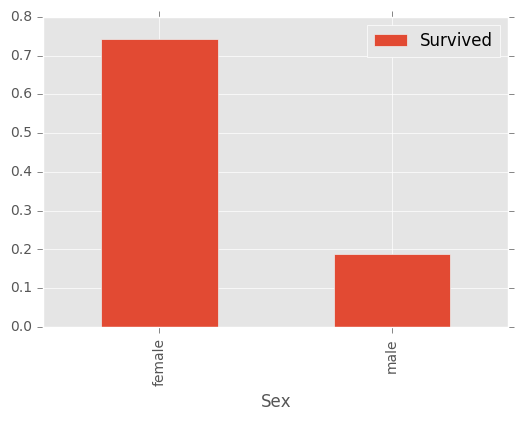

In [2]:
# Sex

df['Sex'].value_counts().plot(kind='bar')
df[['Sex', 'Survived']].groupby(['Sex']).mean().plot(kind='bar')
pyplot.show()

sex_dummies_titanic  = pd.get_dummies(df['Sex'])
sex_dummies_titanic.columns = ['Female','Male']
sex_dummies_titanic.drop('Male', axis=1, inplace=True)

df = df.join(sex_dummies_titanic)

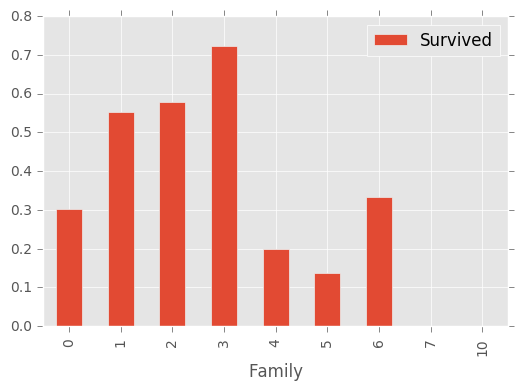

In [3]:
# Family

df['Family'] = df.SibSp + df.Parch
df[['Family', 'Survived']].groupby(['Family']).mean().plot(kind='bar')
pyplot.show()

df = df.drop(['SibSp', 'Parch'], axis=1)

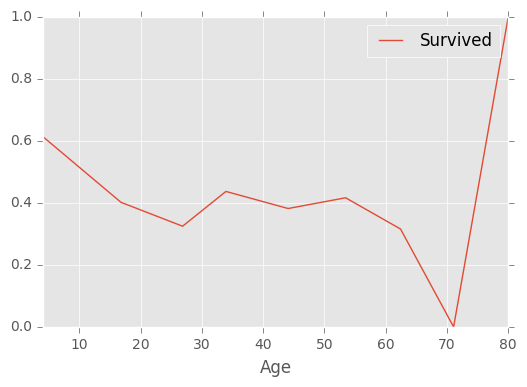

In [4]:
# Age

average_age = df.Age.mean()
df.Age = df.Age.fillna(average_age)

age_bins = np.linspace(0.0, 90.0, num=10)

age_survived_df = df[['Survived', 'Age']].groupby(np.digitize(df.Age, age_bins), as_index=False).mean();
age_survived_df.plot(x='Age', y='Survived')
pyplot.show()

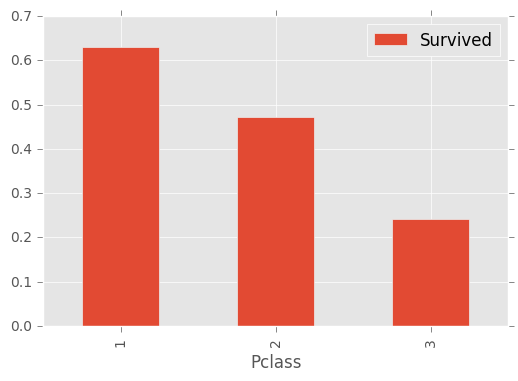

In [5]:
# Pclass

df[['Pclass', 'Survived']].groupby(['Pclass']).mean().plot(kind='bar')
pyplot.show()

pclass_dummies_titanic  = pd.get_dummies(df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

df = df.join(pclass_dummies_titanic)

From the above, we can draw the conclusion that the best columns to use from the dataset are

 1. Female
 2. Pclass
 3. Age 
 4. Family

In [6]:
from sklearn import cross_validation, preprocessing

# prep data
df2 = df[['Age', 'Class_1', 'Class_2', 'Female', 'Family', 'Survived']]
df2 = df2.astype(int).fillna(0)
X = df2.ix[:,['Age', 'Class_1', 'Class_2', 'Female', 'Family']].as_matrix()
X = preprocessing.scale(X)
y = df2.Survived.astype(int).as_matrix()
labels = np.unique(y)

# [X_train, X_cv, y_train, y_cv] = cross_validation.train_test_split(X, y, test_size = 0.1)
# df2.head()

X_train = X
y_train = y


/Users/user/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# create logisitic regression model
from sklearn import linear_model

clf = linear_model.LogisticRegression().fit(X_train, y_train);

print("logistic regression model trained")

# from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import precision_score

# y_cv_pred = clf.predict(X_cv)

# acc = accuracy_score(y_cv_pred, y_cv)
# print('accuracy: ' + str(acc))

# f1 = f1_score(y_cv_pred, y_cv)
# print('f1: ' + str(f1))

# recall = recall_score(y_cv_pred, y_cv)
# print('recall: ' + str(recall))

# precision = precision_score(y_cv_pred, y_cv)
# print('precision: ' + str(precision))

logistic regression model trained


In [8]:
from sklearn import ensemble

random_forest_clf = ensemble.RandomForestClassifier(n_estimators=100).fit(X_train, y_train);
print('Random Forest Classifier Trained')

# y_cv_pred = random_forest_clf.predict(X_cv)

# acc = accuracy_score(y_cv_pred, y_cv)
# print('accuracy: ' + str(acc))

# f1 = f1_score(y_cv_pred, y_cv)
# print('f1: ' + str(f1))

# recall = recall_score(y_cv_pred, y_cv)
# print('recall: ' + str(recall))

Random Forest Classifier Trained


In [11]:
# prep data
data_test_df = pd.read_csv('../input/test.csv')

data_test_df['Family'] = data_test_df.SibSp + data_test_df.Parch

pclass_dummies_titanic  = pd.get_dummies(data_test_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)
data_test_df = data_test_df.join(pclass_dummies_titanic)

sex_dummies_titanic  = pd.get_dummies(data_test_df['Sex'])
sex_dummies_titanic.columns = ['Female','Male']
sex_dummies_titanic.drop('Male', axis=1, inplace=True)
data_test_df = data_test_df.join(sex_dummies_titanic)

X_test = data_test_df[['Age', 'Class_1', 'Class_2', 'Female', 'Family']].fillna(0).astype(int).ix[:,['Age', 'Class_1', 'Class_2', 'Female', 'Family']].as_matrix()
X_test = preprocessing.scale(X_test)

y_pred = clf.predict(X_test)

/Users/user/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [12]:
submission = pd.DataFrame({
        "PassengerId": data_test_df["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('predictions.csv', index=False)